# <span style = "background-color: #FFDDDD"> GO/STOP! - Object Detection 시스템 만들기 [프로젝트]</span>

⭐️ 1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다. KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.  
⭐️ 2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다. 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.  
⭐️ 3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다. 테스트 수행결과 90% 이상의 정확도를 보였다.

---
## <span style = "background-color: #FFFFDD"> 🐶 Environment Settings</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
# useful tools
import os     # get path of data
import copy    # transfer n-d array

# data array
import numpy as np

# image 
from PIL import Image, ImageDraw

# visualization
import matplotlib.pyplot as plt

# machine learning
import tensorflow as tf
import tensorflow.keras as keras

# public dataset
import tensorflow_datasets as tfds

### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

In [2]:
# data properties
DATA_PATH = os.getenv("HOME") + "/aiffel/object_detection/data"
NUM_CLASSES = 8

In [3]:
# model training configurations
#MODEL_PATH = os.getenv("HOME") + "/aiffel/object_detection/data/checkpoints/"
MODEL_PATH = os.getenv("HOME") + "/aiffel/quest/RS7_course_08_going_deeper_cv/going_deeper_cv_12/checkpoints/"

AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 2
EPOCHS = 10

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

In [4]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

### <span style = "background-color: #F0E9FF"> 4. Check GPU settings</span>

In [5]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## <span style = "background-color: #FFFFDD"> 🐶 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Load dataset</span>

In [6]:
(ds_train, ds_val, ds_test), ds_info = tfds.load("kitti",
                                         data_dir=DATA_PATH,
                                         split=["train", "validation", "test"],
                                         #shuffle_files=True,
                                         with_info=True,)

int2str = ds_info.features["objects"]["type"].int2str

print("> Dataset loaded successfully!")

> Dataset loaded successfully!


### <span style = "background-color: #F0E9FF"> 2. Preview dataset</span>

**2-1. Preview overall samples of dataset**

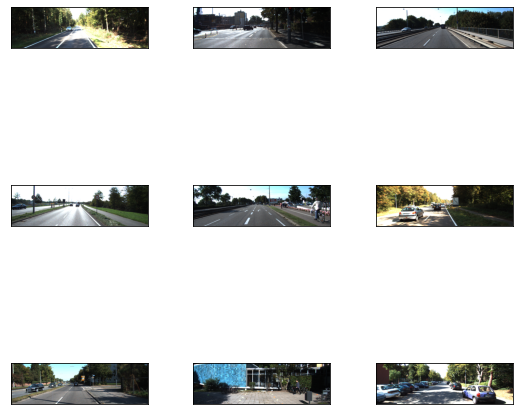

In [7]:
_ = tfds.show_examples(ds_train, ds_info)

In [8]:
print(ds_info)

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

**2-2. Preview information of the one randomly-picked data sample**

>>> Sample
['image', 'image/file_name', 'objects']
--------------------------------------------------------------------------------
>>> Objects
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.40194666, 0.398438  , 0.5124533 , 0.4485185 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.48, 1.87, 4.42]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-3.27,  1.89, 28.56]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.59], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}
--------------------------------------------------------------------------------
>>> Image


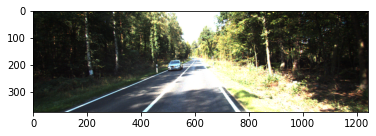

In [9]:
for sample in ds_train.take(1):
    image = sample["image"]
    filename = sample["image/file_name"].numpy().decode("utf-8")
    objects = sample["objects"]
    
    
    print('>>> Sample')
    print(list(sample.keys()))
    
    print_single_divider()
    print('>>> Objects')
    print(objects)

    print_single_divider()
    print(">>> Image")
    plt.imshow(Image.fromarray(image.numpy()))
    plt.show()

**2-3. Preview bounding boxes of the one randomly picked data sample**

In [10]:
# draws rectangles according to bounding box information
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # get coordinate values of bounding box
    width, height = input_image.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height


    # draw bounding boxes on the image
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for rect in rects:
        draw.rectangle(rect, outline=(255,0,0), width=2)

    return input_image

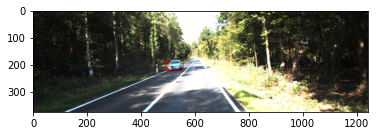

In [11]:
for sample in ds_train.take(1):
    image = sample["image"]
    image = Image.fromarray(image.numpy())

    image_bboxed = visualize_bbox(image, objects["bbox"].numpy())
    plt.imshow(image_bboxed)
    plt.show()

### <span style = "background-color: #F0E9FF"> 3. Define data pre-processing methods</span>

**3-1. Define image pre-processing methods**

In [12]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [13]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [14]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [15]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

**3-2. Define a pipeline method for image pre-processing**

In [16]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

**3-3. Define anchor-box encoding methods**

In [17]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [18]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

**3-4. Define a pipeline method for anchor-box encoding**

In [19]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [20]:
label_encoder = LabelEncoder()

### <span style = "background-color: #F0E9FF"> 4. Perform pre-processing on the dataset</span>

**4-1. Define integrated pipeline method for pre-processing**

In [21]:
def get_preprocess_dataset(ds, batch_size=BATCH_SIZE, is_test=False):
    ds = ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    
    if is_test == True:
        ds = ds.shuffle(8 * batch_size)
    
    ds = ds.padded_batch(batch_size=batch_size,
                         padding_values=(0.0, 1e-8, -1),
                         drop_remainder=True)
    ds = ds.map(label_encoder.encode_batch,
                num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds

**4-2. Perform pre-processing on the dataset** 

In [22]:
ds_train = get_preprocess_dataset(ds_train, batch_size=BATCH_SIZE, is_test=True)

print("> Pre-processing on TRAIN data performed successfully!")

> Pre-processing on TRAIN data performed successfully!


In [23]:
ds_val = get_preprocess_dataset(ds_val, batch_size=1, is_test=False)

print("> Pre-processing on VALIDATION data performed successfully!")

> Pre-processing on VALIDATION data performed successfully!


---
## <span style = "background-color: #FFFFDD"> 🐶 Model Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Define model structure</span>

In [24]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [25]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [26]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [27]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

### <span style = "background-color: #F0E9FF"> 2. Define loss functions</span>

In [28]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

---
## <span style = "background-color: #FFFFDD"> 🐶 Experiments</span>

### <span style = "background-color: #F0E9FF"> 1. Train model</span>

**1-1. Prepare a model instance**

In [29]:
resnet50_backbone = get_backbone()
model = RetinaNet(NUM_CLASSES, resnet50_backbone)

**1-2. Compile the model**

In [30]:
# defines loss function
loss_fn = RetinaNetLoss(NUM_CLASSES)

# defines learning rate function
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

# defines optimizer
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)



# compiles the model
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

**1-3. Train the model**

In [31]:
# loads pre-trained model for quick test
#latest_checkpoint = tf.train.latest_checkpoint(MODEL_PATH)
#model.load_weights(latest_checkpoint)

In [32]:
# defines callback functions
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_PATH, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,)]


# starts model training
history = model.fit(ds_train,
                    validation_data=ds_val,
                    callbacks=callbacks_list,
                    epochs=EPOCHS,)

Epoch 1/10
3173/3173 [==============================] - 1663s 518ms/step - loss: 2.2359 - accuracy: 0.2674 - val_loss: 1.6675 - val_accuracy: 0.2464

Epoch 00001: saving model to /aiffel/aiffel/quest/RS7_course_08_going_deeper_cv/going_deeper_cv_12/checkpoints/weights_epoch_1
Epoch 2/10
3173/3173 [==============================] - 1638s 516ms/step - loss: 1.0010 - accuracy: 0.2470 - val_loss: 1.1634 - val_accuracy: 0.2426

Epoch 00002: saving model to /aiffel/aiffel/quest/RS7_course_08_going_deeper_cv/going_deeper_cv_12/checkpoints/weights_epoch_2
Epoch 3/10
3173/3173 [==============================] - 1637s 516ms/step - loss: 0.7242 - accuracy: 0.2350 - val_loss: 1.1169 - val_accuracy: 0.1994

Epoch 00003: saving model to /aiffel/aiffel/quest/RS7_course_08_going_deeper_cv/going_deeper_cv_12/checkpoints/weights_epoch_3
Epoch 4/10
3173/3173 [==============================] - 1636s 515ms/step - loss: 0.5765 - accuracy: 0.2345 - val_loss: 1.1034 - val_accuracy: 0.2251

Epoch 00004: saving

### <span style = "background-color: #F0E9FF"> 2. Visualize model training history</span>

**2-1. Define a method to visualize model training history**

In [33]:
def visualize_history(history):
    fig = plt.figure(figsize=(15,7))
    
    # visualize training & validation loss
    graph1 = fig.add_subplot(1, 2, 1)
    graph1.plot(history.history["loss"], color="lightpink", label="training")
    graph1.plot(history.history["val_loss"], color="palevioletred", label="validation")
    graph1.set_title("L O S S")
    graph1.set_xlabel("epochs")
    graph1.set_ylabel("loss")
    graph1.grid()
    graph1.legend()
        
    # visualize training & validation accuracy
    graph2 = fig.add_subplot(1, 2, 2)
    graph2.plot(history.history["accuracy"], color="thistle", label="training")
    graph2.plot(history.history["val_accuracy"], color="orchid", label="validation")
    graph2.set_title("A C C U R A C Y")
    graph2.set_xlabel("epochs")
    graph2.set_ylabel("accuracy")
    graph2.grid()
    graph2.legend()    

    fig.tight_layout()
    fig.show()

**2-2. Visualize model training history**

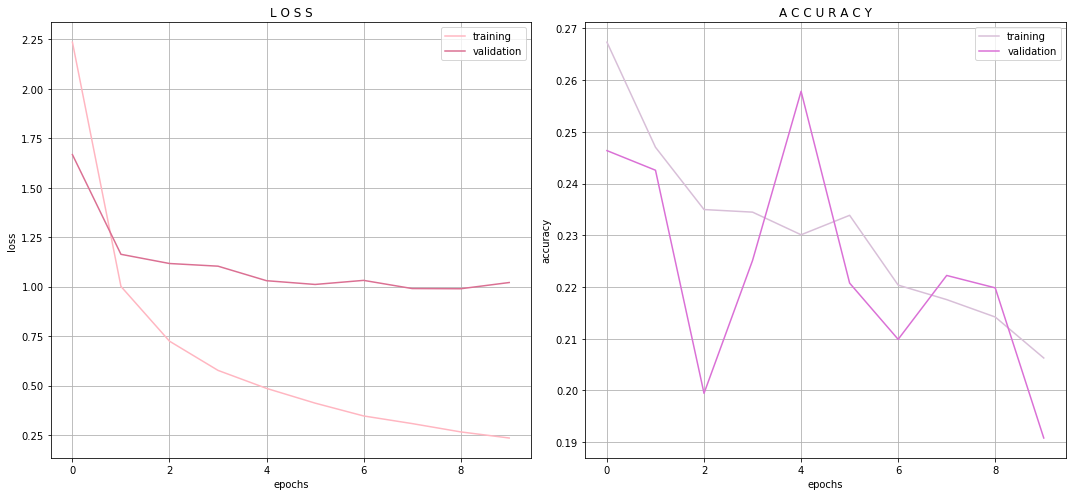

In [34]:
visualize_history(history)

---
## <span style = "background-color: #FFFFDD"> 🐶 Evaluation</span>

### <span style = "background-color: #F0E9FF"> 1. Define visualizing methods</span>

In [35]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [36]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [37]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        width, height = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], width, height, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax
    

In [38]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

### <span style = "background-color: #F0E9FF"> 2. Visualize and analyze metrics</span>

In [39]:
def self_drive_assist(image_path, size_limit=300):
    # load image from file path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    
    # detects objects from the image
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    
    # get object detection results
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    

    # when any human detected, "stop"
    if "Pedestrian" in class_names:
        return "Stop"
    
    else:
        # searches for detected vehicles
        for box in detections.nmsed_boxes[0][:num_detections]:
            width, height = box[2] - box[0], box[3] - box[1]
            
            # when any vehicle detected in close, "stop"
            if width >= size_limit or height >= size_limit:
                return "Stop"
        
        # when nothing dangerous detected, "go"
        return "Go"

In [40]:
def test_system(func):
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = DATA_PATH + "/" + image_file
        pred = func(image_path)
        
        print(">>> Prediction  : ", pred)
        print(">>> Groundtruth : ", answer)
        
        if pred == answer:
            score += 10
    
    print_single_divider()
    print(f"> {score}점입니다.")

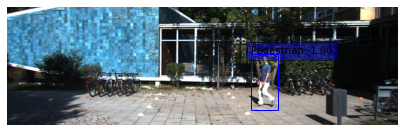

>>> Prediction  :  Stop
>>> Groundtruth :  Stop


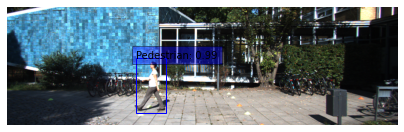

>>> Prediction  :  Stop
>>> Groundtruth :  Stop


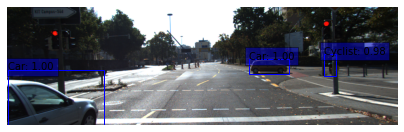

>>> Prediction  :  Stop
>>> Groundtruth :  Stop


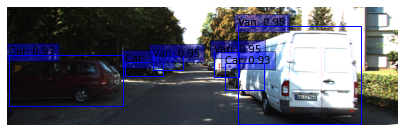

>>> Prediction  :  Stop
>>> Groundtruth :  Stop


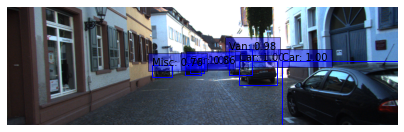

>>> Prediction  :  Stop
>>> Groundtruth :  Stop


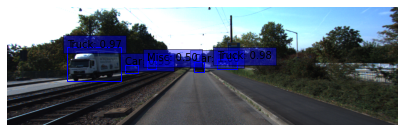

>>> Prediction  :  Go
>>> Groundtruth :  Go


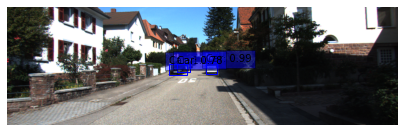

>>> Prediction  :  Go
>>> Groundtruth :  Go


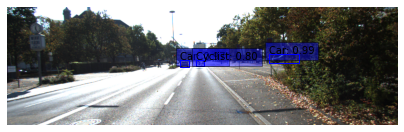

>>> Prediction  :  Go
>>> Groundtruth :  Go


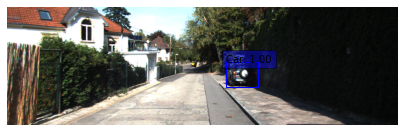

>>> Prediction  :  Go
>>> Groundtruth :  Go


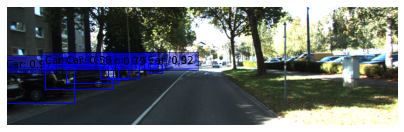

>>> Prediction  :  Go
>>> Groundtruth :  Go
--------------------------------------------------------------------------------
> 100점입니다.


In [41]:
test_system(self_drive_assist)

---
## <span style = "background-color: #FFFFDD"> 🐶 Conclusion</span>

**📝 실험내용 요약**
- object detection을 수행하기 위한 RetinaNet을 이용한 object detection을 수행하였다
- 자율주행 자동차의 상황을 가정. 도로 상황 이미지에 대한 object detection을 수행하고, object detection 결과(보행자 인식 여부, 근거리 차량 인식 여부)에 따라 수행동작을 결정하였다

**📝 실험결과 분석**
- 학습 수행 시 loss는 비교적 매끄럽게 하락하는 추세를 보였으나, accuracy는 들쭉날쭉하게 하락하는 추세를 보였다.
- 시간 제약으로 인해 EPOCHS=10 수준으로 학습을 적게 수행하긴 하였으나, 주어진 평가기준을 달성하기에는 충분하였다.

**📝 회고록**  
- object detection 을 수행하는 데에 필요한 여러가지 개념과 원리를 학습하였다. 다만 비슷한 개념 여러가지를 한꺼번에 배우다보니 헷갈리고 깊이있기 이해하지 못했다. 이론적인 부분은 다음에 다시 복습하도록 해야겠다.
- 자율주행 기능은 인명 피해를 야기하는 등 오류로 인한 손실이 굉장히 큰 편이므로, 완벽에 가까운 성능을 보장할 필요가 있다. 프로젝트에서는 실습 차원에서 간단히 10개의 이미지에 대하여 성능을 실험하였으나, 실제로는 수많은 이미지에 대한 평가가 필요할 것이다. 그런 의미에서 test 데이터 또한 train 데이터 못지 않게 받애하게 준비하는 것도 중요할 것이다. 
- 프로젝트에서는 실습 차원에서 간단히 보행자 및 차량에 대해서만 detection을 수행하였으나, 실제로는 동물이나 건물, 통제 표지판 등 "Stop"을 판별하기 위한 다양한 object detection을 수행할 필요가 있다. 또한 속도제한 표지판 등의 경우 OCR을 통한 표지판 내용 인식 기능도 필요할 것이다.

---